References:
- https://www.tensorflow.org/tutorials/images/transfer_learning
- https://www.tensorflow.org/tutorials/distribute/keras

In [1]:
# Imports
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print(tf.__version__)

2.1.0


In [2]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


In [3]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [4]:
# Available datasets
tfds.list_builders()[:10]

['abstract_reasoning',
 'aeslc',
 'aflw2k3d',
 'amazon_us_reviews',
 'arc',
 'bair_robot_pushing_small',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist']

In [ ]:
(raw_train, raw_validation), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True
)

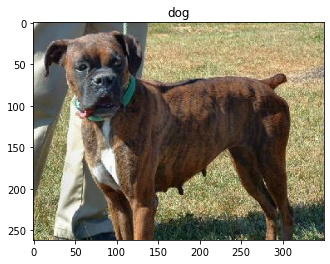

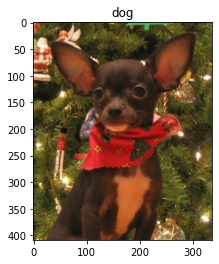

In [6]:
# Show two image from the train set
get_label_name = metadata.features['label'].int2str
for image, label in raw_train.take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

In [7]:
IMG_SIZE = 224 # All images will be resized to 224x224

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [ ]:
# Preprocess the images
train = raw_train.map(format_example)
valid = raw_validation.map(format_example)

In [9]:
# Calculate batch size
batch_size_per_replica = 16
batch_size = batch_size_per_replica * strategy.num_replicas_in_sync

In [10]:
# Prepare batches and randomly shuffle the training images
train_batches = train.shuffle(1024).repeat().batch(batch_size)
valid_batches = valid.repeat().batch(batch_size)

In [11]:
# Inspect the shapes
for (images, labels) in train_batches.take(1):
    pass
print(images.shape, labels.shape)

(64, 224, 224, 3) (64,)


In [12]:
d = train.batch(batch_size)
x = valid.batch(batch_size)

def calculate_steps(dataset):
    steps = 0
    for _ in dataset:
        steps += 1
    return steps
print(calculate_steps(d))
print(calculate_steps(x))

291
73


The following learning schedule comes from [Martin Gorner's notebook](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/07_Keras_Flowers_TPU_xception_fine_tuned_best.ipynb). 

In [13]:
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005 * strategy.num_replicas_in_sync
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

In [14]:
def lrfn(epoch):
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        return lr
    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

1e-05 8.782400000000002e-05


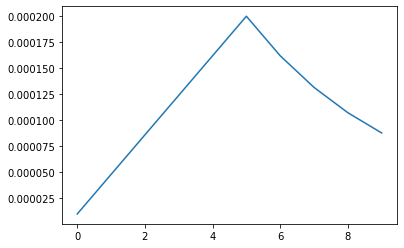

In [15]:
import matplotlib.pyplot as plt

rng = [i for i in range(10)]
y = [lrfn(x) for x in rng]
plt.plot(rng, [lrfn(x) for x in rng])
print(y[0], y[-1])

In [16]:
def get_training_model():
    # Load the VGG16 model but exclude the classification layers
    EXTRACTOR = MobileNetV2(weights='imagenet', include_top=False,
                     input_shape=(224, 224, 3))
    # We are not training the extractor model
    EXTRACTOR.trainable = False
    # Construct the head of the model that will be placed on top of the
    # the base model
    class_head = EXTRACTOR.output
    class_head = GlobalAveragePooling2D()(class_head)
    class_head = Dense(512, activation="relu")(class_head)
    class_head = Dropout(0.5)(class_head)
    class_head = Dense(1)(class_head)

    # Create the new model
    pet_classifier = Model(inputs=EXTRACTOR.input, outputs=class_head)

    # Compile and return the model
    pet_classifier.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                          optimizer="adam",
                          metrics=["accuracy"])

    return pet_classifier

In [17]:
# Set up wandb
##############

import wandb
from wandb.keras import WandbCallback

wandb.init(project="tensorflow-multi-gpu-dist", id="multi-gpu")

W&B Run: https://app.wandb.ai/sayakpaul/tensorflow-multi-gpu-dist/runs/multi-gpu

In [17]:
# Class labels
LABELS = ["cat", "dog"]

In [19]:
import time 

# Train the model
with strategy.scope():
    model = get_training_model()
start = time.time()
model.fit(train_batches,
    steps_per_epoch=291,
    validation_data=valid_batches,
    validation_steps=73,
    epochs=10,
    callbacks=[lr_callback, 
        WandbCallback(data_type="image", labels=LABELS)])
end = time.time()-start
print("model training time", end)
wandb.log({"training_time":end})

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Train for 291 steps, validate for 73 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/10
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


291/291 [==============================] - 82s 282ms/step - loss: 0.4738 - accuracy: 0.7439 - val_loss: 0.2113 - val_accuracy: 0.8733

Epoch 00002: LearningRateScheduler reducing learning rate to 4.8e-05.
Epoch 2/10
291/291 [==============================] - 52s 180ms/step - loss: 0.2058 - accuracy: 0.9102 - val_loss: 0.1063 - val_accuracy: 0.9454

Epoch 00003: LearningRateScheduler reducing learning rate to 8.6e-05.
Epoch 3/10
291/291 [==============================] - 51s 175ms/step - loss: 0.1546 - accuracy: 0.9343 - val_loss: 0.0725 - val_accuracy: 0.9673

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000124.
Epoch 4/10
291/291 [==============================] - 51s 175ms/step - loss: 0.1268 - accuracy: 0.9472 - val_loss: 0.0702 - val_accuracy: 0.9683

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000162.
Epoch 5/10
290/291 [============================>.] - ETA: 0s - loss: 0.1275 - accuracy: 0.9474WARNING:tensorflow:5 out of the last 9 calls to <f

291/291 [==============================] - 52s 178ms/step - loss: 0.1273 - accuracy: 0.9475 - val_loss: 0.0645 - val_accuracy: 0.9720

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 6/10
290/291 [============================>.] - ETA: 0s - loss: 0.1231 - accuracy: 0.9515WARNING:tensorflow:6 out of the last 11 calls to <function _make_execution_function.<locals>.distributed_function at 0x7f07e3945e60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


291/291 [==============================] - 55s 189ms/step - loss: 0.1234 - accuracy: 0.9514 - val_loss: 0.0613 - val_accuracy: 0.9745

Epoch 00007: LearningRateScheduler reducing learning rate to 0.000162.
Epoch 7/10
290/291 [============================>.] - ETA: 0s - loss: 0.1117 - accuracy: 0.9548WARNING:tensorflow:6 out of the last 11 calls to <function _make_execution_function.<locals>.distributed_function at 0x7f07e3945e60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


291/291 [==============================] - 54s 187ms/step - loss: 0.1119 - accuracy: 0.9547 - val_loss: 0.0589 - val_accuracy: 0.9745

Epoch 00008: LearningRateScheduler reducing learning rate to 0.00013160000000000003.
Epoch 8/10
290/291 [============================>.] - ETA: 0s - loss: 0.0954 - accuracy: 0.9625WARNING:tensorflow:6 out of the last 11 calls to <function _make_execution_function.<locals>.distributed_function at 0x7f07e3945e60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


291/291 [==============================] - 55s 188ms/step - loss: 0.0956 - accuracy: 0.9624 - val_loss: 0.0883 - val_accuracy: 0.9634

Epoch 00009: LearningRateScheduler reducing learning rate to 0.00010728000000000003.
Epoch 9/10
290/291 [============================>.] - ETA: 0s - loss: 0.0979 - accuracy: 0.9591WARNING:tensorflow:6 out of the last 11 calls to <function _make_execution_function.<locals>.distributed_function at 0x7f07e3945e60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


291/291 [==============================] - 55s 190ms/step - loss: 0.0980 - accuracy: 0.9589 - val_loss: 0.0826 - val_accuracy: 0.9651

Epoch 00010: LearningRateScheduler reducing learning rate to 8.782400000000002e-05.
Epoch 10/10
290/291 [============================>.] - ETA: 0s - loss: 0.0925 - accuracy: 0.9635WARNING:tensorflow:6 out of the last 11 calls to <function _make_execution_function.<locals>.distributed_function at 0x7f07e3945e60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


291/291 [==============================] - 53s 181ms/step - loss: 0.0924 - accuracy: 0.9635 - val_loss: 0.0809 - val_accuracy: 0.9649
model training time 561.140702009201


In [19]:
# reinit
wandb.init(project="tensorflow-multi-gpu-dist", id="multi-gpu-pre")

W&B Run: https://app.wandb.ai/sayakpaul/tensorflow-multi-gpu-dist/runs/multi-gpu-pre

In [20]:
# Prepare batches and randomly shuffle the training images (this time with prefetch)
train_batches = train.shuffle(1024).repeat().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_batches = valid.repeat().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [22]:
# Train the model
with strategy.scope():
    model = get_training_model()
start = time.time()
model.fit(train_batches,
    steps_per_epoch=291,
    validation_data=valid_batches,
    validation_steps=73,
    epochs=10,
    callbacks=[lr_callback, 
        WandbCallback(data_type="image", labels=LABELS)])
end = time.time()-start
print("model training time", end)
wandb.log({"training_time":end})

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Train for 291 steps, validate for 73 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/10
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


291/291 [==============================] - 81s 278ms/step - loss: 0.5050 - accuracy: 0.7143 - val_loss: 0.2197 - val_accuracy: 0.8833

Epoch 00002: LearningRateScheduler reducing learning rate to 4.8e-05.
Epoch 2/10
291/291 [==============================] - 51s 175ms/step - loss: 0.2018 - accuracy: 0.9153 - val_loss: 0.0860 - val_accuracy: 0.9572

Epoch 00003: LearningRateScheduler reducing learning rate to 8.6e-05.
Epoch 3/10
291/291 [==============================] - 49s 169ms/step - loss: 0.1472 - accuracy: 0.9367 - val_loss: 0.0745 - val_accuracy: 0.9649

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000124.
Epoch 4/10
291/291 [==============================] - 49s 168ms/step - loss: 0.1356 - accuracy: 0.9441 - val_loss: 0.0601 - val_accuracy: 0.9728

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000162.
Epoch 5/10
290/291 [============================>.] - ETA: 0s - loss: 0.1281 - accuracy: 0.9483WARNING:tensorflow:5 out of the last 9 calls to <f

291/291 [==============================] - 54s 185ms/step - loss: 0.1282 - accuracy: 0.9481 - val_loss: 0.0717 - val_accuracy: 0.9677

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 6/10
290/291 [============================>.] - ETA: 0s - loss: 0.1155 - accuracy: 0.9532WARNING:tensorflow:6 out of the last 11 calls to <function _make_execution_function.<locals>.distributed_function at 0x7fdce2dd6440> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


291/291 [==============================] - 51s 176ms/step - loss: 0.1156 - accuracy: 0.9531 - val_loss: 0.0810 - val_accuracy: 0.9651

Epoch 00007: LearningRateScheduler reducing learning rate to 0.000162.
Epoch 7/10
290/291 [============================>.] - ETA: 0s - loss: 0.1126 - accuracy: 0.9543WARNING:tensorflow:6 out of the last 11 calls to <function _make_execution_function.<locals>.distributed_function at 0x7fdce2dd6440> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


291/291 [==============================] - 54s 185ms/step - loss: 0.1125 - accuracy: 0.9543 - val_loss: 0.0541 - val_accuracy: 0.9773

Epoch 00008: LearningRateScheduler reducing learning rate to 0.00013160000000000003.
Epoch 8/10
290/291 [============================>.] - ETA: 0s - loss: 0.1046 - accuracy: 0.9567WARNING:tensorflow:6 out of the last 11 calls to <function _make_execution_function.<locals>.distributed_function at 0x7fdce2dd6440> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


291/291 [==============================] - 49s 170ms/step - loss: 0.1046 - accuracy: 0.9567 - val_loss: 0.0610 - val_accuracy: 0.9747

Epoch 00009: LearningRateScheduler reducing learning rate to 0.00010728000000000003.
Epoch 9/10
290/291 [============================>.] - ETA: 0s - loss: 0.1030 - accuracy: 0.9573WARNING:tensorflow:6 out of the last 11 calls to <function _make_execution_function.<locals>.distributed_function at 0x7fdce2dd6440> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


291/291 [==============================] - 50s 172ms/step - loss: 0.1034 - accuracy: 0.9573 - val_loss: 0.0455 - val_accuracy: 0.9801

Epoch 00010: LearningRateScheduler reducing learning rate to 8.782400000000002e-05.
Epoch 10/10
290/291 [============================>.] - ETA: 0s - loss: 0.0958 - accuracy: 0.9598WARNING:tensorflow:6 out of the last 11 calls to <function _make_execution_function.<locals>.distributed_function at 0x7fdce2dd6440> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


291/291 [==============================] - 49s 169ms/step - loss: 0.0957 - accuracy: 0.9599 - val_loss: 0.0610 - val_accuracy: 0.9758
model training time 538.6890904903412
